In [1]:
import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, DiscriminationThreshold, PrecisionRecallCurve, ROCAUC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, f1_score
from yellowbrick.features import ParallelCoordinates, PCA, RadViz
from yellowbrick.model_selection import RFECV
from yellowbrick.style import set_palette

warnings.simplefilter("ignore", UserWarning)

set_palette("dark")
sns.set(rc={"figure.figsize":(8, 8)})

data_path = Path("../../data").resolve()
os.makedirs(data_path, exist_ok=True)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Preprocessing

In [2]:
tracks_df = pd.read_parquet(data_path / "tracks_v3.pq")

print("tracks_df shape:", tracks_df.shape)
print("...where track_chart_months >= 1:",
      tracks_df[tracks_df["track_chart_months"] >= 1].shape)
print("...where track_chart_months >= 6:",
      tracks_df[tracks_df["track_chart_months"] >= 6].shape)
print("...where artist_country = US:",
      tracks_df[(tracks_df["artist_country"] == "US")].shape)
print("...where artist_country = US and track_chart_months >= 1:",
      tracks_df[(tracks_df["artist_country"] == "US") & (tracks_df["track_chart_months"] >= 1)].shape)
print("...where artist_country = US and track_chart_months >= 6:",
      tracks_df[(tracks_df["artist_country"] == "US") & (tracks_df["track_chart_months"] >= 6)].shape)

print("removing karaoke tracks")
tracks_df = tracks_df[~tracks_df["name"].str.lower().str.contains("karaoke")]
tracks_df = tracks_df[~tracks_df["name"].str.lower().str.contains("originally performed by")]
tracks_df = tracks_df[~tracks_df["name"].str.lower().str.contains("instrumental")]

print("tracks_df shape:", tracks_df.shape)
print("...where track_chart_months >= 1:",
      tracks_df[tracks_df["track_chart_months"] >= 1].shape)
print("...where track_chart_months >= 6:",
      tracks_df[tracks_df["track_chart_months"] >= 6].shape)
print("...where artist_country = US:",
      tracks_df[(tracks_df["artist_country"] == "US")].shape)
print("...where artist_country = US and track_chart_months >= 1:",
      tracks_df[(tracks_df["artist_country"] == "US") & (tracks_df["track_chart_months"] >= 1)].shape)
print("...where artist_country = US and track_chart_months >= 6:",
      tracks_df[(tracks_df["artist_country"] == "US") & (tracks_df["track_chart_months"] >= 6)].shape)

audio_features = [
    "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness",
    "instrumentalness", "liveness", "valence", "tempo", "time_signature",
]

artist_features = [
    "artist_chart_tracks",
    "artist_nominations",
    "artist_wins",
    "artist_releases",
    "artist_chart_months",
    "artist_chart_months_recently",
    "artist_releases_recently",
    # "major_label",
]


def chart_status(track):
    if track["track_chart_peak"] == 1:
        return "peaked"
    elif track["track_chart_months"] > 3:
        return "charted_3months"
    elif track["track_chart_months"] >= 1:
        return "charted"
    else:
        return "uncharted"


tracks_df["chart_status"] = tracks_df.apply(chart_status, axis=1)
tracks_df["chart_months"] = tracks_df["track_chart_months"].apply(lambda months: months if months <= 5 else 5)
tracks_df["has_female_artist"] = tracks_df["artist_gender"].apply(lambda gender: int("female" in gender))


def create_test_train_datasets(
        df, x_vars, months=1, test_size=0.40, random_state=42,
        y_label="track_chart_months"):
    df = df[x_vars + [y_label]]
    if "major_label" in df.columns:
        df = df.drop(columns="major_label")
    if "chart_status" in df.columns:
        df = df.drop(columns="chart_status")
    if "chart_months" in df.columns:
        df = df.drop(columns="chart_months")
    df = df.dropna()
    X = df.drop(columns=["track_chart_months"])
    y = (df["track_chart_months"] >= months).astype(int)
    return train_test_split(X, y, stratify=y, test_size=test_size,
                            random_state=random_state)


X_audio_train, X_audio_test, y_audio_train, y_audio_test = create_test_train_datasets(tracks_df, audio_features, months=1)
X_artist_train, X_artist_test, y_artist_train, y_artist_test = create_test_train_datasets(tracks_df, artist_features, months=1)

us_tracks_df = tracks_df[(tracks_df["artist_country"] == "US")]

tracks_df shape: (14967, 69)
...where track_chart_months >= 1: (3259, 69)
...where track_chart_months >= 6: (671, 69)
...where artist_country = US: (5817, 69)
...where artist_country = US and track_chart_months >= 1: (2090, 69)
...where artist_country = US and track_chart_months >= 6: (409, 69)
removing karaoke tracks
tracks_df shape: (14923, 69)
...where track_chart_months >= 1: (3220, 69)
...where track_chart_months >= 6: (662, 69)
...where artist_country = US: (5814, 69)
...where artist_country = US and track_chart_months >= 1: (2089, 69)
...where artist_country = US and track_chart_months >= 6: (409, 69)


In [62]:
tracks_df[audio_features].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,14921.000000,14921.000000,14921.000000,14921.000000,14921.000000,14921.000000,14921.000000,14921.000000,14921.000000,14921.000000,14921.000000,14921.000000
mean,0.648819,0.653054,5.309296,-6.580287,0.595805,0.106500,0.241888,0.037445,0.179747,0.505684,121.580153,3.958850
std,0.152102,0.186476,3.615535,3.054328,0.490752,0.104975,0.260063,0.155936,0.142385,0.230427,29.200819,0.297074
min,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.552000,0.537000,2.000000,-7.793000,0.000000,0.038300,0.034000,0.000000,0.094400,0.327000,98.001000,4.000000
50%,0.665000,0.676000,6.000000,-6.031000,1.000000,0.059400,0.141000,0.000000,0.123000,0.506000,120.045000,4.000000
75%,0.759000,0.794000,8.000000,-4.696000,1.000000,0.133000,0.374000,0.000118,0.221000,0.684000,140.003000,4.000000
max,0.983000,0.999000,11.000000,1.509000,1.000000,0.954000,0.996000,0.993000,0.986000,0.982000,230.186000,5.000000


In [11]:
tracks_df[artist_features].describe()

,artist_chart_tracks,artist_nominations,artist_wins,artist_releases,artist_chart_months,artist_chart_months_recently,artist_releases_recently,major_label
count,14923.000000,14923.000000,14923.000000,14923.000000,14923.000000,14923.000000,14923.000000,6363.000000
mean,3.308182,0.413523,0.140253,17.318368,7.678818,3.227166,10.399048,0.689926
std,6.117903,1.436946,0.663414,22.982106,19.783667,8.241838,15.900763,0.462560
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,5.000000,1.000000
75%,4.000000,0.000000,0.000000,24.000000,3.000000,1.000000,13.000000,1.000000
max,31.000000,26.000000,20.000000,334.000000,193.000000,87.000000,282.000000,1.000000


In [7]:
# tracks released in 2017 by artists who have not previously charted
tracks_new_artists_2017 = tracks_df[
    (tracks_df["year"] == 2017)
    & (tracks_df["artist_chart_months"] == 0)
    & (tracks_df["artist_country"] == "US")
    # & (tracks_df["artist_lifetime_chart_months"] >= 1)
    # & (tracks_df["track_chart_months"] >= 1)
][["artists", "name", "track_chart_months", "artist_chart_months", "artist_lifetime_chart_months"]]
tracks_new_artists_2017

,artists,name,track_chart_months,artist_chart_months,artist_lifetime_chart_months
82,"Dumpstaphunk, Trombone Shorty",Justice,0.0,0.0,0.0
114,Lee Brice,Rumor,2.0,0.0,5.0
144,Two Feet,Love Is a Bitch,0.0,0.0,0.0
212,Portugal. The Man,Feel It Still,9.0,0.0,9.0
359,Judah & the Lion,Suit And Jacket,0.0,0.0,0.0
...,...,...,...,...,...
14777,Russ,Cherry Hill,0.0,0.0,0.0
14850,"Lil Yachty, Migos",Peek A Boo,0.0,0.0,13.0
14851,Chikybombom La Pantera,Tengo La Personalidad,0.0,0.0,0.0
14860,Great Good Fine Ok,Take It or Leave It,0.0,0.0,0.0


## Target variable analysis

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='track_chart_peak', ylabel='Density'>

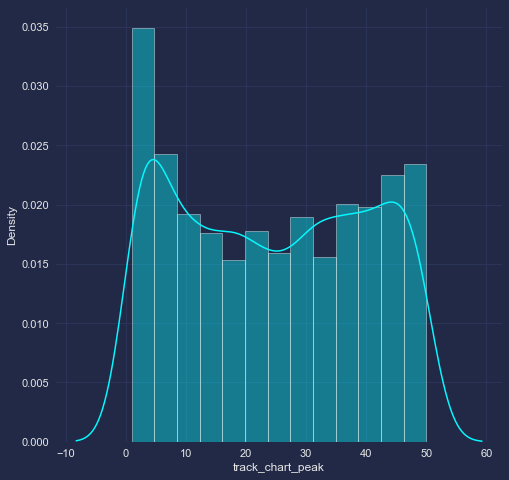

In [53]:
sns.distplot((tracks_df["track_chart_peak"]))

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='track_chart_months', ylabel='Density'>

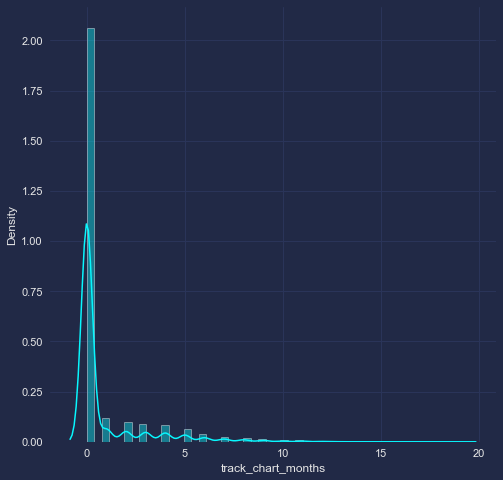

In [54]:
sns.distplot((tracks_df["track_chart_months"]))

In [7]:
print(len(tracks_df[tracks_df["track_chart_months"] > 5]))
print(len(tracks_df[tracks_df["track_chart_months"] > 4]))
print(len(tracks_df[tracks_df["track_chart_months"] > 3]))
print(len(tracks_df[tracks_df["track_chart_months"] > 2]))
print(len(tracks_df[tracks_df["track_chart_months"] > 1]))
print(len(tracks_df[tracks_df["track_chart_months"] == 1]))

663
1024
1495
2000
2554
673


## Audio feature analysis

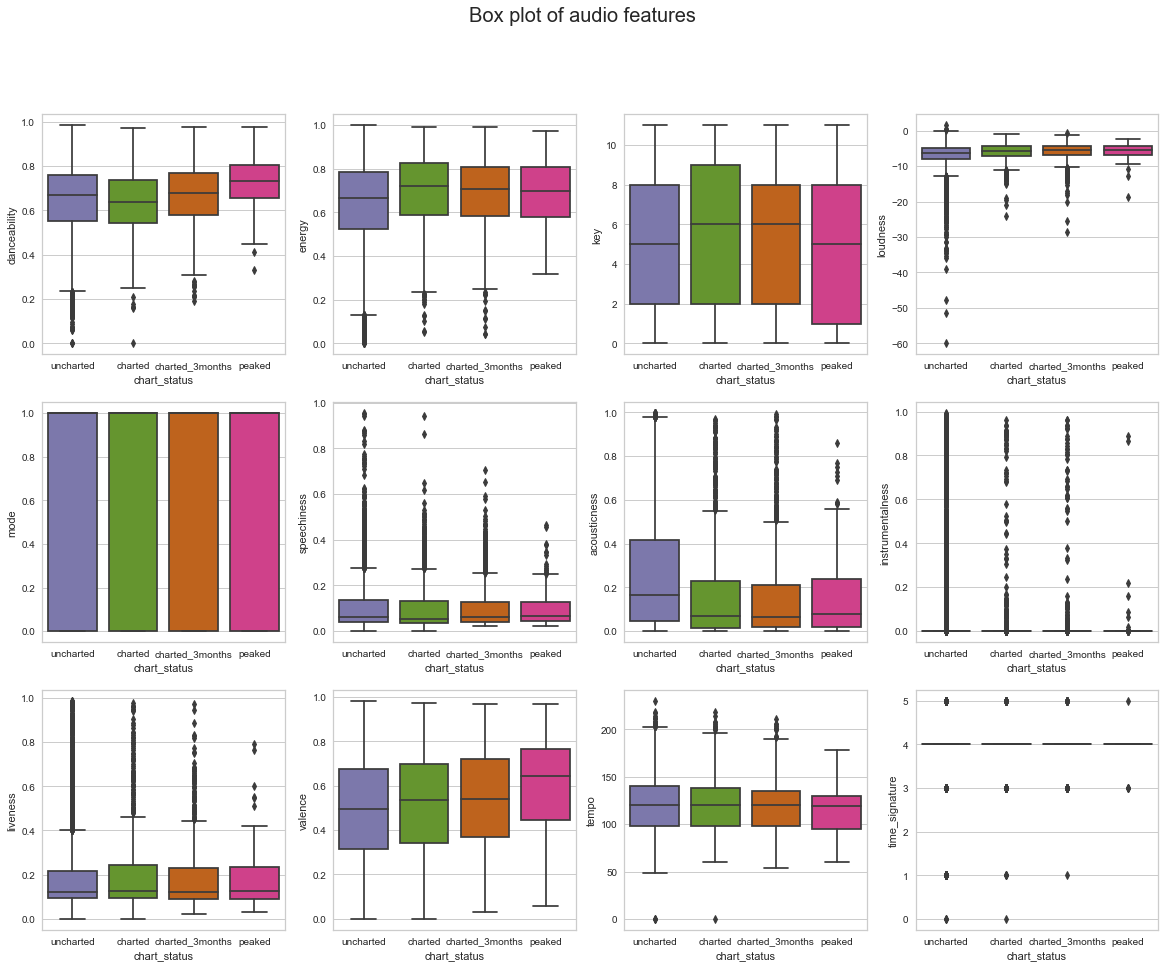

In [8]:
ncols = 4
nrows = int(len(audio_features) / 4)

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols, 5 * nrows))
fig.suptitle("Box plot of audio features", fontsize=20)

for row in range(nrows):
    for col in range(ncols):
        idx = (row * ncols) + (col + 1) - 1
        if idx > len(audio_features):
            break
        sns.boxplot(data=tracks_df, x="chart_status", y=audio_features[idx], ax=axs[row, col],
                    order=["uncharted", "charted", "charted_3months", "peaked"])

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

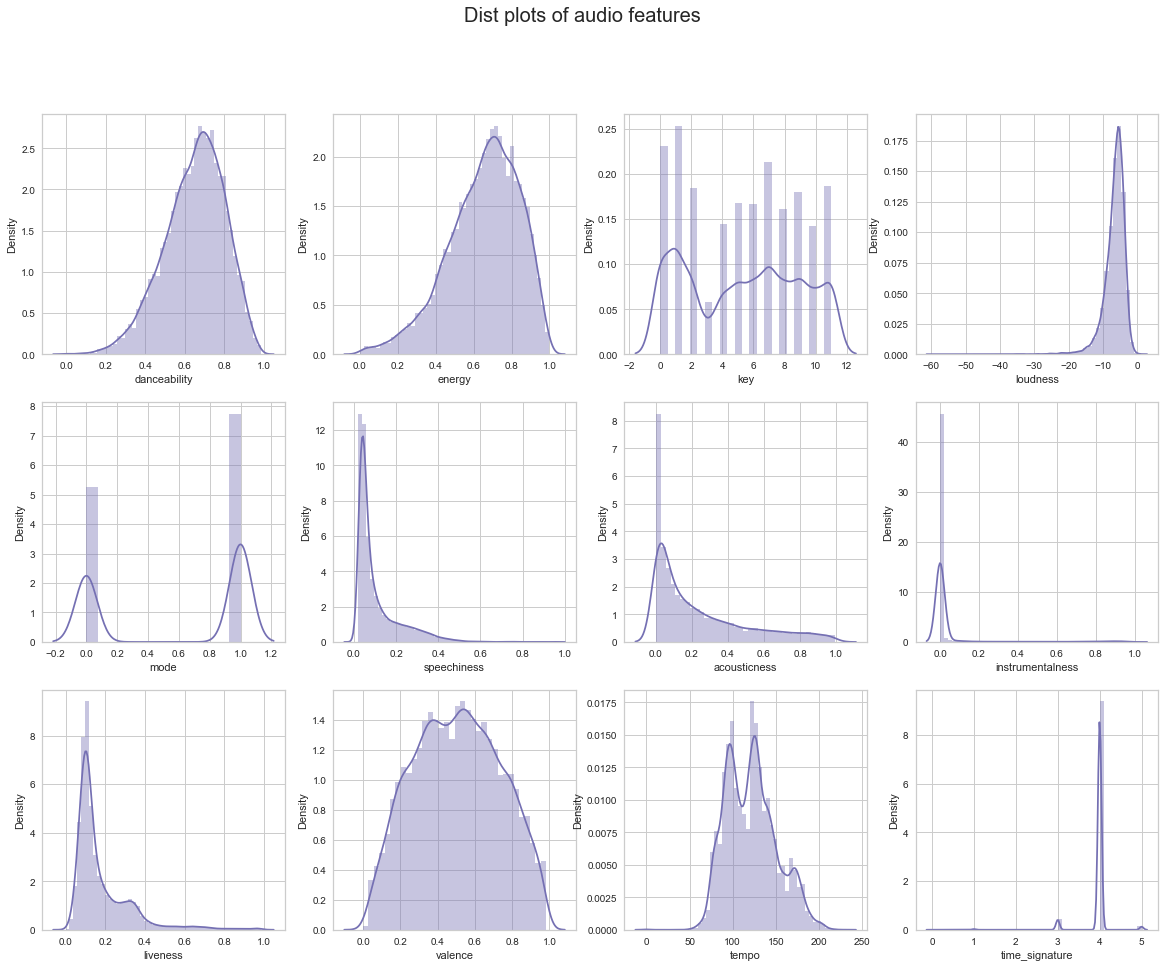

In [9]:
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols, 5 * nrows))
fig.suptitle("Dist plots of audio features", fontsize=20)

ncols = 4
nrows = int(len(audio_features) / 4)

for row in range(nrows):
    for col in range(ncols):
        idx = (row * ncols) + (col + 1) - 1
        if idx > len(audio_features):
            break
        sns.distplot(tracks_df[audio_features[idx]], ax=axs[row, col]),
                    #order=["uncharted", "charted", "charted_3months", "peaked"])

<AxesSubplot:xlabel='tempo', ylabel='Density'>

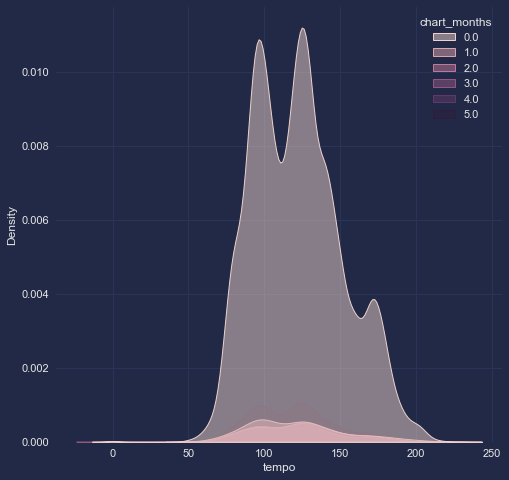

In [55]:
sns.kdeplot(data=tracks_df, x="tempo", hue="chart_months", fill=True, alpha=0.5)

## Artist feature analysis

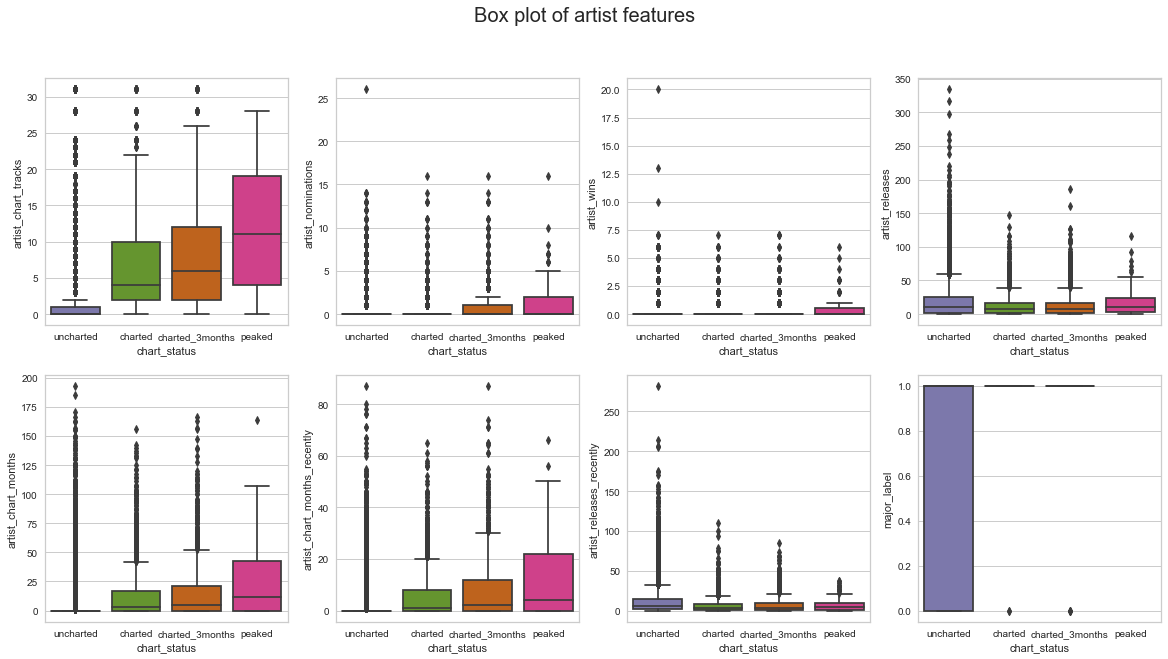

In [11]:
ncols = 4
nrows = int(len(artist_features) / 4)

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols, 5 * nrows))
fig.suptitle("Box plot of artist features", fontsize=20)

for row in range(nrows):
    for col in range(ncols):
        idx = (row * ncols) + (col + 1) - 1
        if idx > len(artist_features):
            break
        sns.boxplot(data=tracks_df, x="chart_status", y=artist_features[idx], ax=axs[row, col],
                    order=["uncharted", "charted", "charted_3months", "peaked"])

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

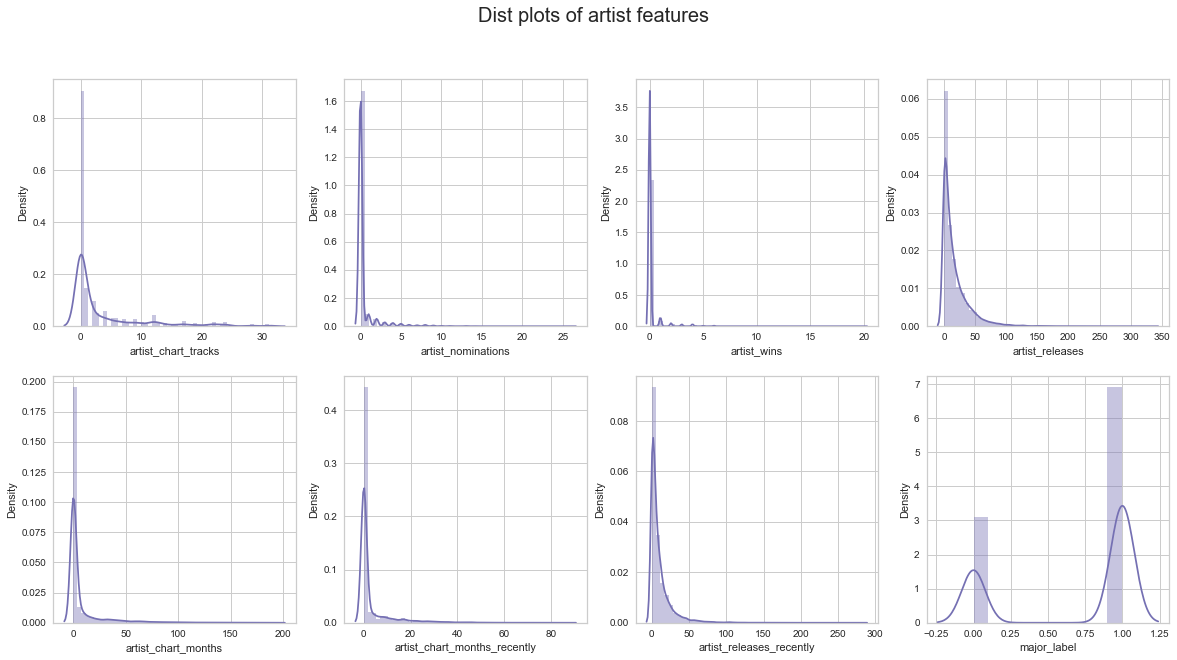

In [12]:
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols, 5 * nrows))
fig.suptitle("Dist plots of artist features", fontsize=20)

ncols = 4
nrows = int(len(artist_features) / 4)

for row in range(nrows):
    for col in range(ncols):
        idx = (row * ncols) + (col + 1) - 1
        if idx > len(artist_features):
            break
        sns.distplot(tracks_df[artist_features[idx]], ax=axs[row, col])

## Revenue Analysis

According to Chart2000: "rough guess is that each unit of Indicative Revenue score represents something like $5,000 of TOTAL revenue generated across the **whole music delivery chain** (in year 2000 dollars). It is reasonable to expect that artists will get at the very most about 10% of this revenue."

In [12]:
df_ = tracks_df.copy()
df_["revenue_est_total"] = df_["track_chart_indicativerevenue"] * 5000.0 / 1000.0
df_["revenue_est_artist"] = df_["revenue_est_total"] * .10
df_["revenue_est_total"].describe()

count     14923.000000
mean       5564.831738
std       15672.759211
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      270898.290000
Name: revenue_est_total, dtype: float64

In [13]:
df_[["artists", "name", "revenue_est_total"]].sort_values(["revenue_est_total"], ascending=False)

,artists,name,revenue_est_total
7410,The Weeknd,Blinding Lights,270898.290
11357,Ed Sheeran,Shape of You,164355.470
9553,Lewis Capaldi,Someone You Loved,164177.095
14286,Post Malone,Circles,161989.040
6642,Billie Eilish,bad guy,152528.525
...,...,...,...
5619,Ramil',Сияй,0.000
5621,Mallrat,Better,0.000
5622,ZHU,Stay Closer,0.000
5623,Hillsong Young & Free,Gracious Tempest - Live,0.000


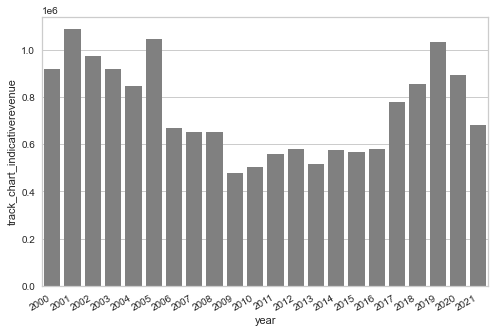

In [14]:
year_revenue = (
    tracks_df
        .groupby("year")
        .aggregate({"track_chart_indicativerevenue": "sum"})
        .reset_index()
)
year_revenue = year_revenue[year_revenue["year"] != 2022]
plot = sns.barplot(x="year", y="track_chart_indicativerevenue", data=year_revenue, color="gray")
plot.get_figure().autofmt_xdate()

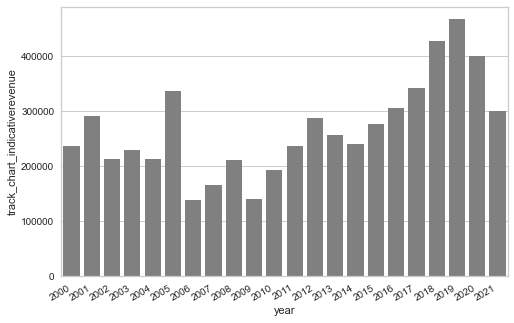

In [15]:
year_revenue = (
    tracks_df
        [tracks_df["track_chart_months"] > 6]
        .groupby("year")
        .aggregate({"track_chart_indicativerevenue": "sum"})
        .reset_index()
)
year_revenue = year_revenue[year_revenue["year"] != 2022]
plot = sns.barplot(x="year", y="track_chart_indicativerevenue", data=year_revenue, color="gray")
plot.get_figure().autofmt_xdate()

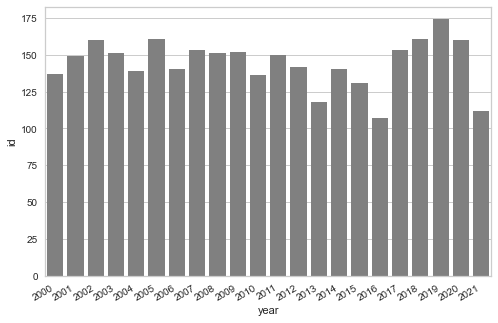

In [16]:
year_count = (
    tracks_df
        [tracks_df["track_chart_months"] > 0]
        .groupby("year")
        .aggregate({"id": "count"})
        .reset_index()
)
year_count = year_count[year_count["year"] != 2022]
plot = sns.barplot(x="year", y="id", data=year_count, color="gray")
plot.get_figure().autofmt_xdate()

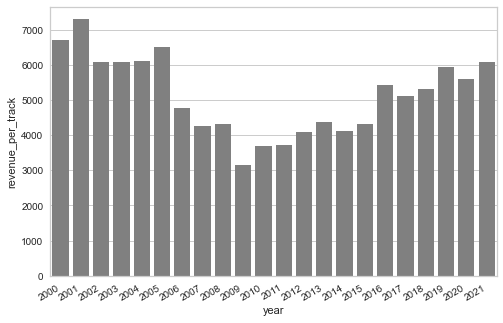

In [17]:
# normalized revenue
year_revenue = (
    tracks_df
        [tracks_df["track_chart_months"] > 0]
        .groupby("year")
        .aggregate({
            "track_chart_indicativerevenue": "sum",
            "id": "count",
        })
        .reset_index()
)
year_revenue = year_revenue[year_revenue["year"] != 2022]
year_revenue["revenue_per_track"] = year_revenue["track_chart_indicativerevenue"] / year_revenue["id"]
plot = sns.barplot(x="year", y="revenue_per_track", data=year_revenue, color="gray")
plot.get_figure().autofmt_xdate()

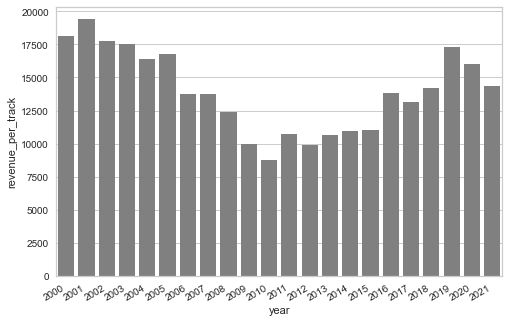

In [18]:
# normalized revenue
year_revenue = (
    tracks_df
    [tracks_df["track_chart_months"] > 6]
        .groupby("year")
        .aggregate({
        "track_chart_indicativerevenue": "sum",
        "id": "count",
    })
        .reset_index()
)
year_revenue = year_revenue[year_revenue["year"] != 2022]
year_revenue["revenue_per_track"] = year_revenue["track_chart_indicativerevenue"] / year_revenue["id"]
plot = sns.barplot(x="year", y="revenue_per_track", data=year_revenue, color="gray")
plot.get_figure().autofmt_xdate()

## Charts Analysis

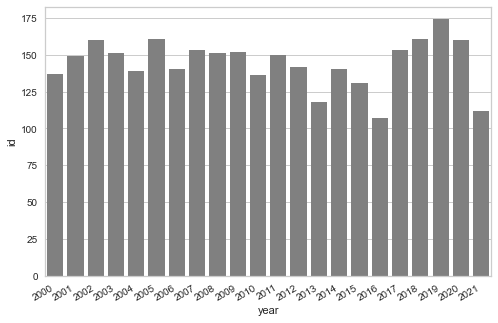

In [19]:
# number of charting songs per year
year_charts = (
    tracks_df
    [tracks_df["track_chart_months"] > 0]
        .groupby("year")
        .aggregate({
            "track_chart_months": "sum",
            "id": "count",
        })
        .reset_index()
)
year_charts = year_charts[year_charts["year"] != 2022]
plot = sns.barplot(x="year", y="id", data=year_charts, color="gray")
plot.get_figure().autofmt_xdate()

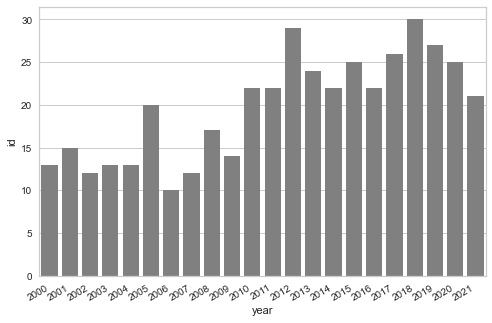

In [20]:
# number of 6+ months charting songs per year
year_charts = (
    tracks_df
    [tracks_df["track_chart_months"] > 6]
        .groupby("year")
        .aggregate({
            "track_chart_months": "sum",
            "id": "count",
    })
    .reset_index()
)
year_charts = year_charts[year_charts["year"] != 2022]
plot = sns.barplot(x="year", y="id", data=year_charts, color="gray")
plot.get_figure().autofmt_xdate()

In [21]:
(
    tracks_df
        [tracks_df["track_chart_months"] > 6]
        .sort_values(["year", "track_chart_months"], ascending=(True, False))
        [["year", "name", "artists", "track_chart_months"]]
)

,year,name,artists,track_chart_months
2197,2000,Hanging By A Moment,Lifehouse,11.0
1067,2000,Kryptonite,3 Doors Down,10.0
11325,2000,I Hope You Dance,Lee Ann Womack,9.0
11492,2000,In the End,Linkin Park,9.0
1065,2000,Bent,Matchbox Twenty,8.0
...,...,...,...,...
5718,2022,Love Yourself,Justin Bieber,9.0
4959,2022,We Are Young,"fun., Janelle Monáe",8.0
5942,2022,I Love It - Nari & Milani Remix,"Icona Pop, Charli XCX",8.0
11924,2022,What Do You Mean?,Justin Bieber,8.0


## Audio feature analysis

/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_20341/2310459692.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df["track_chart_months"] = model_df["track_chart_months"].apply(lambda v: 5 if v > 5 else v)
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/yellowbrick/features/radviz.py:199: RuntimeWarning: invalid value encountered in true_divide
  xy = (s * row_).sum(axis=0) / row.sum()


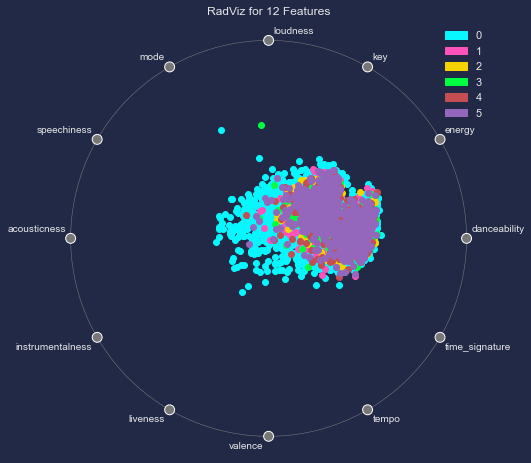

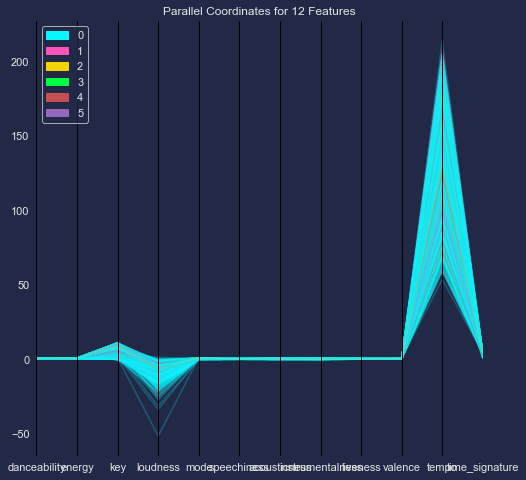

<AxesSubplot:title={'center':'Parallel Coordinates for 12 Features'}>

In [40]:
model_df = tracks_df[audio_features + ["track_chart_months"]]
model_df["track_chart_months"] = model_df["track_chart_months"].apply(lambda v: 5 if v > 5 else v)
model_df = model_df.dropna().reset_index(drop=True)
X = model_df.drop(columns=["track_chart_months"]).reset_index(drop=True)
y = model_df["track_chart_months"]

# classes = [0, 1]
classes = [0, 1, 2, 3, 4, 5]
visualizer = RadViz(classes=classes)
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

visualizer = ParallelCoordinates(
    classes=classes, features=X.columns, sample=0.25, shuffle=True, random_state=42
)
visualizer.fit_transform(X, y)
visualizer.show()

## Artist feature analysis

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/yellowbrick/features/radviz.py:199: RuntimeWarning: invalid value encountered in true_divide
  xy = (s * row_).sum(axis=0) / row.sum()


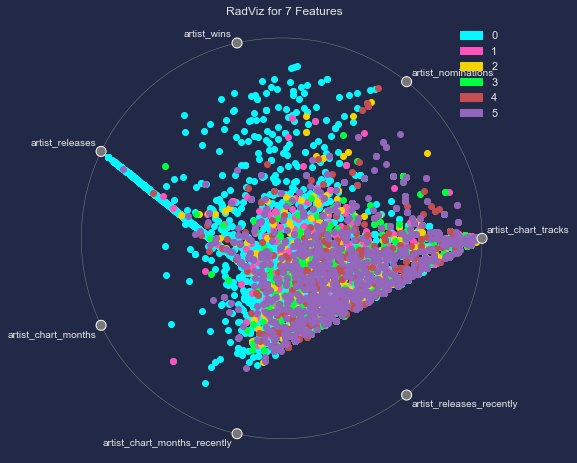

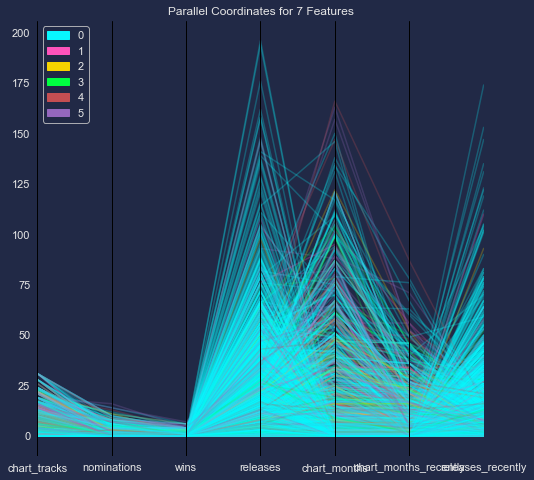

<AxesSubplot:title={'center':'Parallel Coordinates for 7 Features'}>

In [41]:
model_df = tracks_df[artist_features + ["track_chart_months"]].drop(columns="major_label")
model_df["track_chart_months"] = model_df["track_chart_months"].apply(lambda v: 5 if v > 5 else v)
model_df = model_df.dropna().reset_index(drop=True)
X = model_df.drop(columns=["track_chart_months"]).reset_index(drop=True)
y = model_df["track_chart_months"]

# classes = [0, 1]
classes = [0, 1, 2, 3, 4, 5]
visualizer = RadViz(classes=classes)
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

feature_names_clean = [col.replace("artist_", "") for col in X.columns]
visualizer = ParallelCoordinates(
    classes=classes, features=feature_names_clean, sample=0.25, shuffle=True, random_state=42
)
visualizer.fit_transform(X, y)
visualizer.show()

## Feature importance

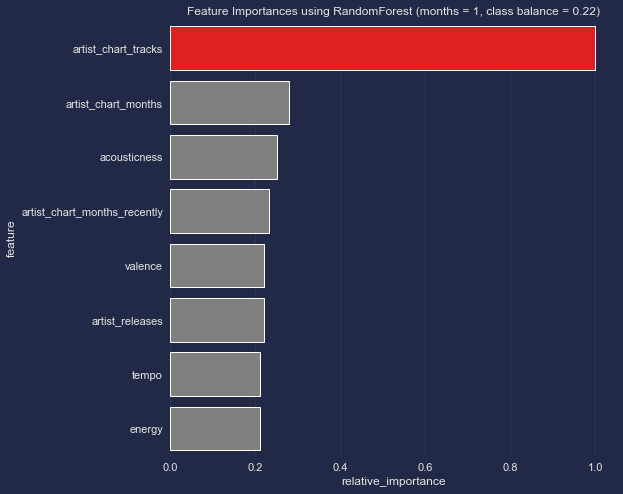

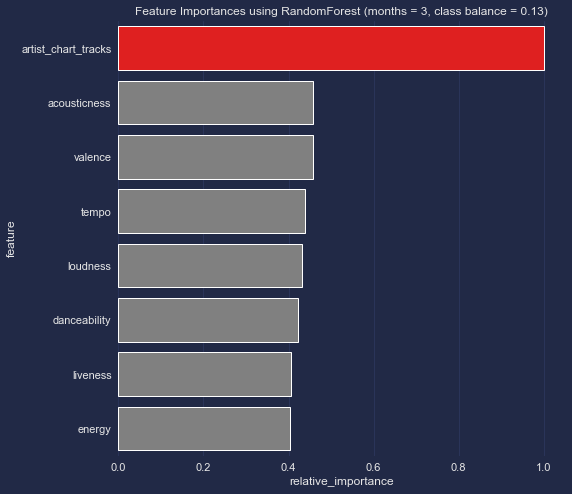

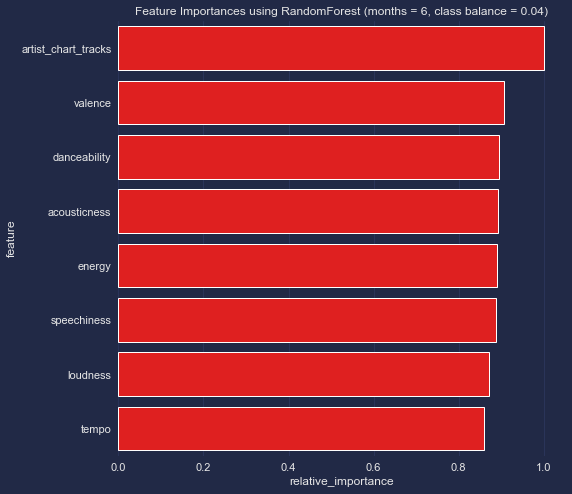

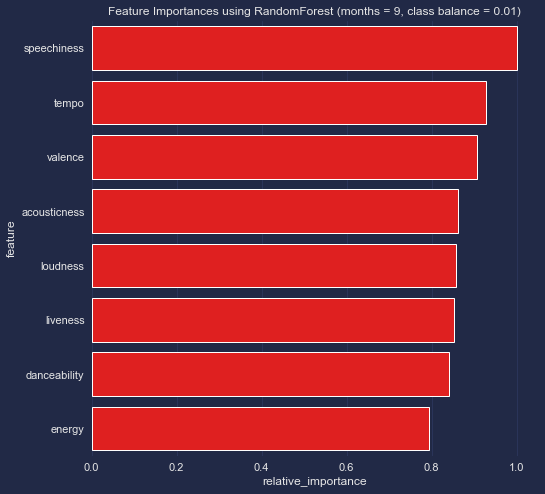

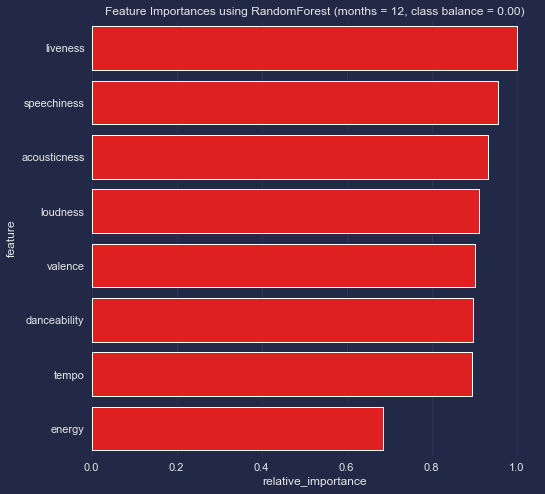

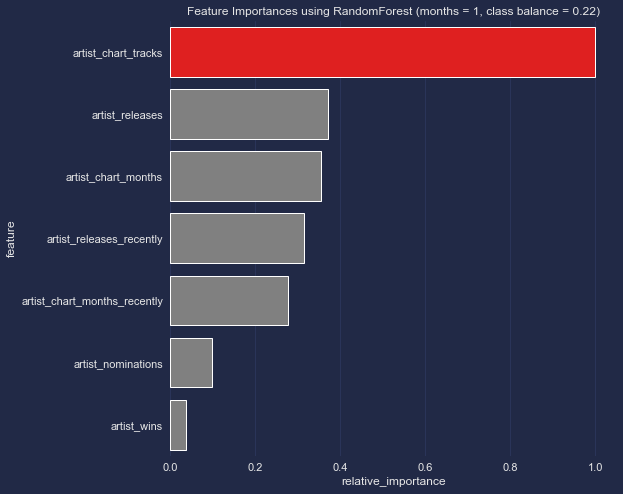

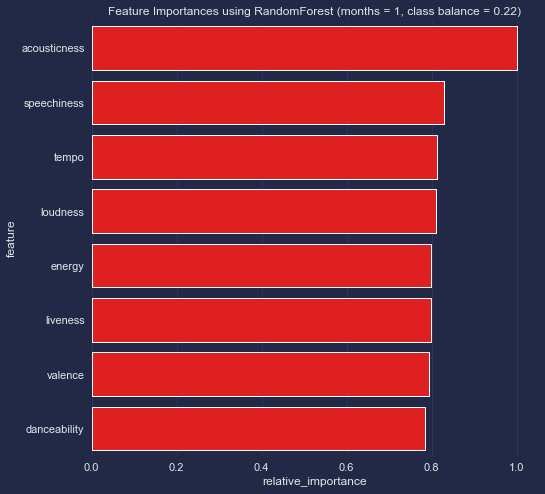

In [52]:
def plot_feature_importance(tracks_df, months, features=audio_features + artist_features, limit=8):
    X_train, X_test, y_train, y_test = create_test_train_datasets(tracks_df, x_vars=features, months=months)
    class_balance = (y_test == 1).sum() / len(y_test)

    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)

    feature_importances = pd.DataFrame(
        list(zip(X_train.columns, rf.feature_importances_)),
        columns=["feature", "importance"]
    ).sort_values("importance", ascending=False)
    feature_importances["relative_importance"] = feature_importances["importance"] / np.max(feature_importances["importance"])
    feature_importances = feature_importances.sort_values("importance", ascending=False).head(limit)

    ax = plt.figure(figsize=(8, 8))
    g = sns.barplot(x="relative_importance", y="feature", data=feature_importances,
                    palette=np.where(feature_importances["relative_importance"] >= 0.6, "red", "gray"))
    g.set_title(f"Feature Importances using RandomForest (months = {months}, class balance = {class_balance:.2f})")


plot_feature_importance(tracks_df, 1)
plot_feature_importance(tracks_df, 3)
plot_feature_importance(tracks_df, 6)
plot_feature_importance(tracks_df, 9)
plot_feature_importance(tracks_df, 12)
plot_feature_importance(tracks_df, 1, features=artist_features)
plot_feature_importance(tracks_df, 1, features=audio_features)

## Feature selection

In [19]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler


def create_model(X, y, selected_features, scale=False):
    if scale:
        scaler = StandardScaler()
        X_ = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
    else:
        X_ = X.copy()
    X_ = X_[selected_features]
    StandardScaler()
    X_ = sm.add_constant(X_)
    model = sm.GLM(y, X_, family=sm.families.Binomial())
    return model.fit()


def forward_selection(X, y, significance_level=0.05, scale=False):
    initial_features = X.columns.tolist()
    selected_features = []
    while len(initial_features) > 0:
        remaining_features = list(set(initial_features) - set(selected_features))
        pvalues = pd.Series(index=remaining_features)
        for column in remaining_features:
            model = create_model(X, y, selected_features=selected_features + [column], scale=scale)
            pvalues[column] = model.pvalues[column]
        best_pval = pvalues.min()
        if best_pval <= significance_level:
            best_feature = pvalues.idxmin()
            selected_features.append(best_feature)
            print(f"feature added: {best_feature}, p-val={best_pval:.8f}")
        else:
            break
    return selected_features



def backward_selection(X, y, initial_list=[], significance_level=0.05,
                       scale=False, verbose=True):
    included = list(X.columns)
    while True:
        changed = False
        model = create_model(X, y, selected_features=included, scale=scale)
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > significance_level:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"Drop {worst_feature} with p-value: {worst_pval}")
        if not changed:
            break
    return included


df_ = tracks_df[audio_features + ["track_chart_months"]].sample(frac=0.05).dropna()
X = df_[audio_features]
y = (df_["track_chart_months"] >= 1).astype(int)

print("Forward:")
forward_selected_features = forward_selection(X, y, significance_level=0.15)
print("Backward:")
backward_selected_features = backward_selection(X, y, significance_level=0.15)
print("Forward (w/ Scaling):")
forward_selected_scaled_features = forward_selection(X, y, significance_level=0.15, scale=True)
print("Backward (w/ Scaling):")
backward_selected_scaled_features = backward_selection(X, y, significance_level=0.15, scale=True)

Forward:
feature added: acousticness, p-val=0.00000522
feature added: instrumentalness, p-val=0.14124556
feature added: danceability, p-val=0.14751355


/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_73301/2231462931.py:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pvalues = pd.Series(index=remaining_features)
/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_73301/2231462931.py:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pvalues = pd.Series(index=remaining_features)
/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_73301/2231462931.py:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pvalues = pd.Series(index=remaining_features)
/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_73301/2231462931.py:23: DeprecationWarning: The de

Backward:
Drop speechiness with p-value: 0.7005741121310984
Drop valence with p-value: 0.6462229787973032
Drop tempo with p-value: 0.5629885046953176
Drop key with p-value: 0.42388624231293126
Drop instrumentalness with p-value: 0.24636022306521765
Drop mode with p-value: 0.210252755091633
Drop time_signature with p-value: 0.19450545617514114
Drop liveness with p-value: 0.17964737440848
Forward (w/ Scaling):
feature added: acousticness, p-val=0.00000522


/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_73301/2231462931.py:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pvalues = pd.Series(index=remaining_features)
/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_73301/2231462931.py:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pvalues = pd.Series(index=remaining_features)
/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_73301/2231462931.py:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pvalues = pd.Series(index=remaining_features)


feature added: instrumentalness, p-val=0.14124556
feature added: danceability, p-val=0.14751355
Backward (w/ Scaling):
Drop speechiness with p-value: 0.7005741121310969
Drop valence with p-value: 0.6462229787973034
Drop tempo with p-value: 0.5629885046952974
Drop key with p-value: 0.423886242312959
Drop instrumentalness with p-value: 0.2463602230652161
Drop mode with p-value: 0.210252755091631
Drop time_signature with p-value: 0.19450545617515014
Drop liveness with p-value: 0.17964737440847967


/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_73301/2231462931.py:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pvalues = pd.Series(index=remaining_features)


In [20]:
forward_selected_features.sort()
backward_selected_features.sort()
forward_selected_scaled_features.sort()
backward_selected_scaled_features.sort()
print(forward_selected_features)
print(backward_selected_features)
print(forward_selected_scaled_features)
print(backward_selected_scaled_features)

['acousticness', 'danceability', 'instrumentalness']
['acousticness', 'danceability', 'energy', 'loudness']
['acousticness', 'danceability', 'instrumentalness']
['acousticness', 'danceability', 'energy', 'loudness']


In [25]:
selected_model = create_model(X, y, backward_selected_scaled_features)
print(selected_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:     track_chart_months   No. Observations:                  747
Model:                            GLM   Df Residuals:                      742
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -367.87
Date:                Sat, 12 Mar 2022   Deviance:                       735.73
Time:                        12:37:34   Pearson chi2:                     771.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.04253
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.6472      1.004      1.640   

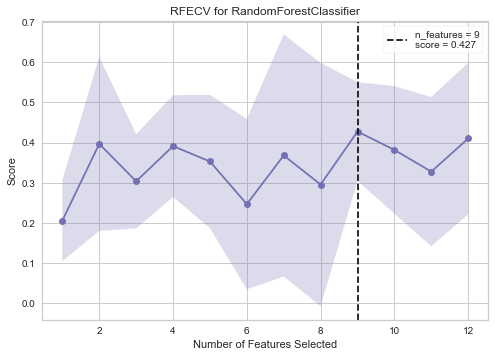

['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']


In [17]:
df_ = tracks_df[audio_features + ["track_chart_months"]].sample(frac=0.05).dropna()

X = df_[audio_features]
y = (df_["track_chart_months"] >= 1).astype(int)

cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring="precision")
visualizer.fit(X, y)
visualizer.show()

selected_audio_features_1_month = list(visualizer.rfe_estimator_.get_feature_names_out(X.columns))
print(selected_audio_features_1_month)

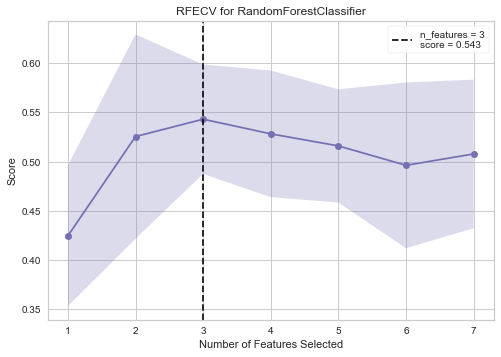

['artist_chart_tracks', 'artist_releases', 'artist_chart_months']


In [26]:
df_ = tracks_df.sample(frac=0.05)

X = df_[artist_features].drop(columns="major_label")
y = (df_["track_chart_months"] >= 1).astype(int)

cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring="precision")
visualizer.fit(X, y)
visualizer.show()

selected_artist_features_1_month = list(visualizer.rfe_estimator_.get_feature_names_out(X.columns))
print(selected_artist_features_1_month)

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-pack

KeyboardInterrupt: 

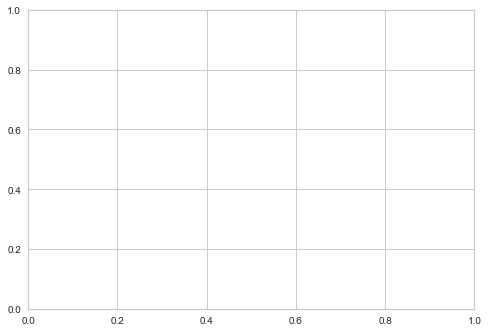

In [27]:
df_ = tracks_df.sample(frac=0.05)

X = df_[audio_features]
y = (df_["track_chart_months"] >= 6).astype(int)

cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring="precision")
visualizer.fit(X, y)
visualizer.show()

selected_audio_features_6_months = list(visualizer.rfe_estimator_.get_feature_names_out(X.columns))
print(selected_audio_features_6_months)

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-pack

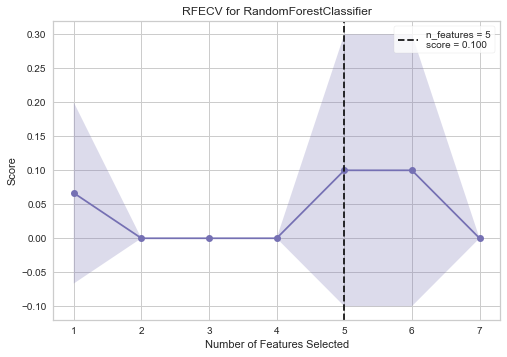

['artist_chart_tracks', 'artist_releases', 'artist_chart_months', 'artist_chart_months_recently', 'artist_releases_recently']


In [29]:
df_ = tracks_df.sample(frac=0.05)

X = df_[artist_features].drop(columns="major_label")
y = (df_["track_chart_months"] >= 6).astype(int)

cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring="precision")
visualizer.fit(X, y)
visualizer.show()

selected_artist_features_6_months = list(visualizer.rfe_estimator_.get_feature_names_out(X.columns))
print(selected_artist_features_6_months)

In [ ]:
df_ = tracks_df.sample(frac=0.05)

X = df_[audio_features + artist_features].drop(columns="major_label")
y = (df_["track_chart_months"] >= 1).astype(int)

cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring="precision")
visualizer.fit(X, y)
visualizer.show()

selected_features_1_month = list(visualizer.rfe_estimator_.get_feature_names_out(X.columns))
print(selected_features_1_month)

In [ ]:
df_ = tracks_df.sample(frac=0.05)

X = df_[audio_features + artist_features].drop(columns="major_label")
y = (df_["track_chart_months"] >= 6).astype(int)

cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring="precision")
visualizer.fit(X, y)
visualizer.show()

selected_features_6_months = list(visualizer.rfe_estimator_.get_feature_names_out(X.columns))
print(selected_features_6_months)